#### **RETE NEURALE CON DATI TABULARI APPLICATA AL DATASET CLINVAR**

Importo la libreria per la costruzione di una rete neurale con dati tabulari.

In [7]:
from fastai.tabular.all import *
set_seed(42)
from warnings import simplefilter
set_seed(42)
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

*Pulizia dei dati*

- Sostituzione dei valori mancanti indicati con un punto con NaN
- Eliminazione delle righe in cui la variabile target è mancante
- Eliminazione delle colonne con più dell'80% di valori mancanti
- Eliminazione delle righe dove la variabile target non assume un valore standard
- Unione delle classi con più di un valore nella variabile target alle classi standard

Classi standard:
- Benign
- Likely benign
- Pathogenic
- Likely pathogenic
- Uncertain significance

In [8]:
df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    df[df.columns[column]] = pd.to_numeric(df[df.columns[column]], errors='coerce')
df.replace(to_replace='.', value=np.nan, inplace=True)
df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)


/tmp/ipykernel_667/4191454376.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


##### **Costruzione delle reti neurali**

Estrazione delle colonne con valori numerici e categorici

In [9]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df.select_dtypes(include=[np.number]).replace(to_replace=np.nan, value=0, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)


Costruzione del dataset

In [10]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

Caricamento dei dati

In [11]:
dls = to.dataloaders(bs=1024)

Learner di default

In [12]:
learn = tabular_learner(dls, metrics=accuracy)

Ricerca del learning rate ottimale

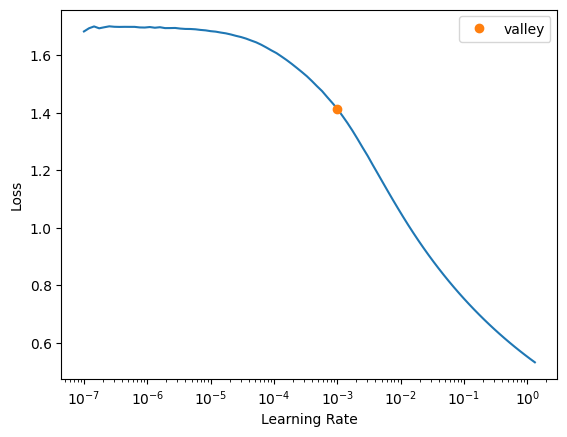

In [13]:
lr = learn.lr_find()

Adddestramento del modello

epoch,train_loss,valid_loss,accuracy,time
0,1.471182,1.607988,0.154031,00:00
1,1.239708,1.544198,0.664260,00:00
2,1.066918,1.471025,0.722022,00:00
3,0.915210,1.397677,0.746089,00:00
4,0.784908,1.332234,0.762936,00:00
5,0.675681,1.281885,0.754513,00:00
6,0.584777,1.236145,0.740072,00:00
7,0.509472,1.193508,0.725632,00:00
8,0.447126,1.160913,0.711191,00:00
9,0.394979,1.128036,0.694344,00:00


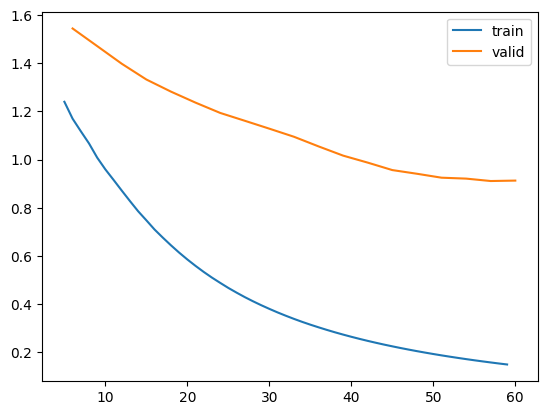

In [14]:
learn.fit(20, lr)
learn.recorder.plot_loss()

Matrice che interpreta i risultati della rete neurale. Mostra il valore reale (righe) e il valore predetto (colonne)

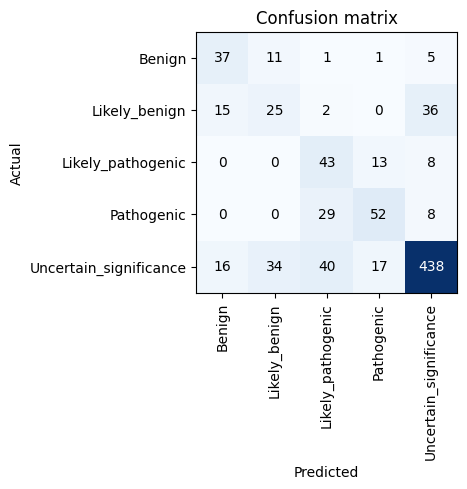

In [15]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [16]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.cancer.tsv', sep='\t')
mixed_type = [98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730]
for column in mixed_type:
    test_df[test_df.columns[column]] = pd.to_numeric(test_df[test_df.columns[column]], errors='coerce')
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
#targets = test_df.pop('clinvar_clnsig')
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

/tmp/ipykernel_667/208669869.py:1: DtypeWarning: Columns (650,651,681,682,684,685,717) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.cancer.tsv', sep='\t')


(#2) [0.1721903383731842,0.9459853768348694]

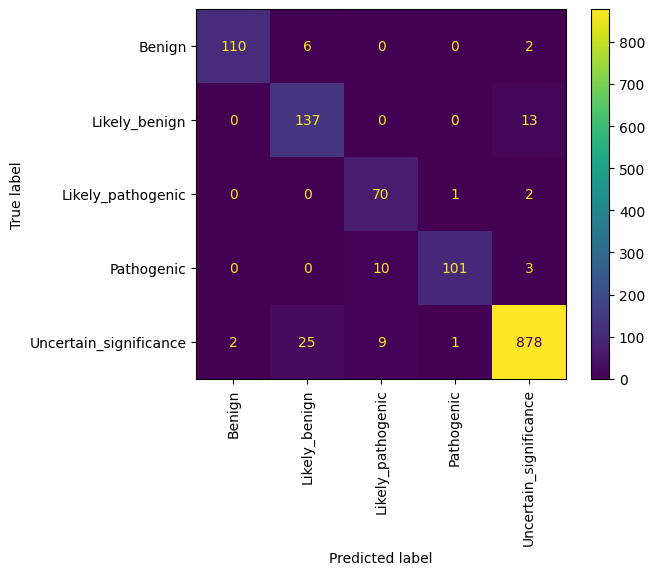

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

##### **Learner con loss function**

In [ ]:
vocab = list(dls.vocab)

Loss function creata tramite inverso del peso delle classi

In [ ]:
values_dict = df['clinvar_clnsig'].value_counts().to_dict()
class_weights = [1/values_dict[item] for item in vocab]
class_weights_tensor = torch.FloatTensor(class_weights).cuda()
loss_fn = CrossEntropyLossFlat(axis=1, weight=class_weights_tensor)

In [ ]:
torch.cuda.empty_cache()
learn_loss = tabular_learner(dls, metrics=accuracy, loss_func=loss_fn)

In [ ]:
lr_loss = learn.lr_find()

In [ ]:
learn_loss.fit(10, lr_loss)
learn_loss.recorder.plot_loss()

In [ ]:
interp_loss = ClassificationInterpretation.from_learner(learn_loss)
interp_loss.plot_confusion_matrix()

##### **Oversampling del training set**

In [ ]:
dls.vocab

Estrazione dei valori del training set, creazione di un nuovo training set con oversampling delle classi minoritarie e settaggio del valore is_valid a False

In [40]:
o = dls.train.items[dls.train.items['clinvar_clnsig'] != 4]
train_oversamp = pd.concat([dls.train.items, o, o, o, o, o], axis=0)
train_oversamp['is_valid'] = False
train_oversamp['clinvar_clnsig'].value_counts()

clinvar_clnsig
3    2232
4    2178
1    1722
2    1638
0    1308
Name: count, dtype: int64

In [47]:
valid_df = dls.valid.items
valid_df['is_valid'] = True
oversample_df = pd.concat((train_oversamp, valid_df))
splitted_oversample = ColSplitter()(oversample_df)
to_oversampled = TabularPandas(oversample_df, procs=[Categorify, FillMissing, Normalize],
                    cat_names = cat_cols,
                    cont_names = num_cols,
                    y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                    splits=splitted_oversample)
to_oversampled.show(3)

,ref,alt,aaref,aaalt,rs_dbSNP,aapos,genename,Ensembl_geneid,Ensembl_transcriptid,Ensembl_proteinid,Uniprot_acc,Uniprot_entry,HGVSc_ANNOVAR,HGVSp_ANNOVAR,HGVSc_snpEff,HGVSp_snpEff,HGVSc_VEP,HGVSp_VEP,APPRIS,GENCODE_basic,TSL,VEP_canonical,cds_strand,refcodon,codonpos,codon_degeneracy,Ancestral_allele,AltaiNeandertal,Denisova,VindijiaNeandertal,SIFT_score,SIFT_converted_rankscore,SIFT_pred,SIFT4G_score,SIFT4G_converted_rankscore,SIFT4G_pred,Polyphen2_HDIV_score,Polyphen2_HDIV_rankscore,Polyphen2_HDIV_pred,Polyphen2_HVAR_score,Polyphen2_HVAR_rankscore,Polyphen2_HVAR_pred,LRT_score,LRT_converted_rankscore,LRT_pred,LRT_Omega,MutationTaster_score,MutationTaster_pred,MutationTaster_model,MutationTaster_AAE,FATHMM_score,FATHMM_converted_rankscore,FATHMM_pred,PROVEAN_score,PROVEAN_converted_rankscore,PROVEAN_pred,VEST4_score,VEST4_rankscore,MetaSVM_score,MetaSVM_rankscore,MetaSVM_pred,MetaLR_score,MetaLR_rankscore,MetaLR_pred,Reliability_index,MetaRNN_score,MetaRNN_rankscore,MetaRNN_pred,M-CAP_score,M-CAP_rankscore,M-CAP_pred,REVEL_score,REVEL_rankscore,MVP_score,MVP_rankscore,MPC_score,MPC_rankscore,PrimateAI_score,PrimateAI_rankscore,PrimateAI_pred,DEOGEN2_score,DEOGEN2_rankscore,DEOGEN2_pred,BayesDel_addAF_score,BayesDel_addAF_rankscore,BayesDel_addAF_pred,BayesDel_noAF_score,BayesDel_noAF_rankscore,BayesDel_noAF_pred,ClinPred_score,ClinPred_rankscore,ClinPred_pred,LIST-S2_score,LIST-S2_rankscore,LIST-S2_pred,fathmm-MKL_coding_pred,fathmm-MKL_coding_group,fathmm-XF_coding_score,fathmm-XF_coding_rankscore,fathmm-XF_coding_pred,Eigen-raw_coding,Eigen-raw_coding_rankscore,Eigen-phred_coding,Eigen-PC-raw_coding,Eigen-PC-raw_coding_rankscore,Eigen-PC-phred_coding,GERP++_NR,GERP++_RS,GERP++_RS_rankscore,SiPhy_29way_pi,SiPhy_29way_logOdds,SiPhy_29way_logOdds_rankscore,bStatistic,bStatistic_converted_rankscore,clinvar_id,clinvar_trait,clinvar_review,clinvar_hgvs,clinvar_MedGen_id,Uniprot_acc(HGNC/Uniprot),Uniprot_id(HGNC/Uniprot),Entrez_gene_id,CCDS_id,Refseq_id,ucsc_id,MIM_id,OMIM_id,Gene_full_name,Pathway(ConsensusPathDB),Function_description,Disease_description,MIM_phenotype_id,MIM_disease,Orphanet_disorder_id,Orphanet_disorder,Orphanet_association_type,HPO_id,HPO_name,GO_biological_process,GO_cellular_component,GO_molecular_function,Expression(egenetics),Expression(GNF/Atlas),Interactions(IntAct),Interactions(BioGRID),Interactions(ConsensusPathDB),P(HI),HIPred_score,HIPred,GHIS,P(rec),RVIS_EVS,RVIS_percentile_EVS,LoF-FDR_ExAC,RVIS_ExAC,RVIS_percentile_ExAC,ExAC_pLI,ExAC_pRec,ExAC_pNull,ExAC_nonTCGA_pLI,ExAC_nonTCGA_pRec,ExAC_nonTCGA_pNull,ExAC_nonpsych_pLI,ExAC_nonpsych_pRec,ExAC_nonpsych_pNull,gnomAD_pLI,gnomAD_pRec,gnomAD_pNull,ExAC_del.score,ExAC_dup.score,ExAC_cnv.score,ExAC_cnv_flag,GDI,GDI-Phred,Gene damage prediction (all disease-causing genes),Gene damage prediction (all Mendelian disease-causing genes),Gene damage prediction (Mendelian AD disease-causing genes),Gene damage prediction (Mendelian AR disease-causing genes),Gene damage prediction (all PID disease-causing genes),Gene damage prediction (PID AD disease-causing genes),Gene damage prediction (PID AR disease-causing genes),Gene damage prediction (all cancer disease-causing genes),Gene damage prediction (cancer recessive disease-causing genes),Gene damage prediction (cancer dominant disease-causing genes),LoFtool_score,SORVA_LOF_MAF0.005_HetOrHom,SORVA_LOF_MAF0.005_HomOrCompoundHet,SORVA_LOF_MAF0.001_HetOrHom,SORVA_LOF_MAF0.001_HomOrCompoundHet,SORVA_LOForMissense_MAF0.005_HetOrHom,SORVA_LOForMissense_MAF0.005_HomOrCompoundHet,SORVA_LOForMissense_MAF0.001_HetOrHom,SORVA_LOForMissense_MAF0.001_HomOrCompoundHet,Essential_gene_CRISPR,Essential_gene_CRISPR2,Essential_gene_gene-trap,Gene_indispensability_score,Gene_indispensability_pred,MGI_mouse_gene,MGI_mouse_phenotype,#chr,pos(1-based),hg19_chr,hg19_pos(1-based),hg18_chr,hg18_pos(1-based),MutationTaster_converted_rankscore,CADD_raw,CADD_raw_rankscore,CADD_phred,CADD_raw_hg19,CADD_raw_rankscore_hg19,CADD_phred_hg19,DANN_scor

In [ ]:
dls_os = to_oversampled.dataloaders(bs=1024)

In [ ]:
torch.cuda.empty_cache()
oversampled_learner = tabular_learner(dls_os, metrics=accuracy)

In [ ]:
lr_os = oversampled_learner.lr_find()

In [ ]:
oversampled_learner.fit(20, lr_os)
oversampled_learner.recorder.plot_loss()

In [ ]:
interp_os = ClassificationInterpretation.from_learner(oversampled_learner)
interp_os.plot_confusion_matrix()

##### **Undersampling del dataframe**

Campionamento casuale della classe maggioritaria per bilanciare il dataset

In [ ]:
df_un = df.drop(df[df['clinvar_clnsig'] == 'Uncertain_significance'].sample(frac=0.85).index)
df_un['clinvar_clnsig'].value_counts()  

In [ ]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_un))
df_data = df_un.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df_un.select_dtypes(include=[np.number]).replace(to_replace=np.nan, value=0, inplace=True)
df_un = df_un.sample(frac=1).reset_index(drop=True)

In [ ]:
to_un = TabularPandas(df_un, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [ ]:
dls_un = to_un.dataloaders(bs=1024)

In [ ]:
torch.cuda.empty_cache()
learn_un = tabular_learner(dls_un, metrics=accuracy)

In [ ]:
lr_un = learn_un.lr_find()

In [ ]:
learn_un.fit(20, lr)
learn_un.recorder.plot_loss()

In [ ]:
interp_un = ClassificationInterpretation.from_learner(learn_un)
interp_un.plot_confusion_matrix()

##### **Oversampling del dataframe**

Estrazione dei valori del dataframe e creazione di un nuovo dataframe con oversampling delle classi minoritarie

In [ ]:
df2 = df[df.clinvar_clnsig != 'Uncertain_significance']

df_conc = pd.concat([df, df2, df2, df2, df2, df2], axis=0)

In [ ]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df_conc))
df_data = df_conc.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df_conc.select_dtypes(include=[np.number]).replace(to_replace=np.nan, value=0, inplace=True)
df_conc = df_conc.sample(frac=1).reset_index(drop=True)

In [ ]:
to = TabularPandas(df_conc, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [ ]:
dls = to.dataloaders(bs=1024)

In [ ]:
torch.cuda.empty_cache()
learn = tabular_learner(dls, metrics=accuracy)

In [ ]:
lr = learn.lr_find()

In [ ]:
learn.fit(20, lr)
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
test_df = pd.read_csv('clinvar.hg19.chr22.dbnsfp.cancer.vcf', sep='\t')
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.replace(regex='^[.;]+$', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
#targets = test_df.pop('clinvar_clnsig')
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)